In [2]:
from skimage import measure
import numpy as np
import argparse
import trimesh
import polyscope
import sys
import torch
import tqdm
import kaolin
import pygdel3d
import scipy.spatial
import voronoiaccel
import pytorch3d.ops
import time
import matplotlib.pyplot as plt
import sdfpred_utils.sdfpred_utils as su

In [3]:
CUT = 0.1
RESOLUTION = 256
HOTSPOT_PATH = "hotspots_model/gargoyle.pth"
# OURS_PATH = "outputs/jul31/cvt100abs_beta_final.npz"
# OURS_PATH = "outputs/jul31/cdp1000_v0_cvt0_clipTrue_buildFalse_upsampling0_num_centroids32_target_size32_min_dist0_lr0.0005_noise0.0_nocvt__final.npz"
#OURS_PATH = "outputs/jul31/cvt100abs_beta_gumbel2_nosdf_final.npz"
# OURS_PATH = "outputs/jul31/100abs_beta_noSDF_noNorm_final.npz"
OURS_PATH = "outputs/jul31/100abs_beta_fixSDF_final.npz"
OURS_INIT_PATH = "outputs/jul31/mt_init.npz"
# MT_PATH = "outputs/jul31/mt_final.npz"
# MT_PATH = "outputs/jul31/mt_100abs_beta_final.npz"
MT_PATH = "outputs/jul31/mt_100abs_beta_noSDF_final.npz"
# MT_PATH = "outputs/jul31/mt_100abs_beta_noCVT_final.npz"

def create_cut_plane(
    bbox=0.5 * np.array([[-1, 1], [-1, 1], [-1, 1]]),
    cut_value=CUT,
    resolution=RESOLUTION,
    eps=0.1,
    orientation='z'
):
    """
    Create a cut plane for the model at the specified cut value and orientation.
    orientation: 'x', 'y', or 'z'
    """
    x = np.linspace(bbox[0, 0] - eps, bbox[0, 1] + eps, resolution)
    y = np.linspace(bbox[1, 0] - eps, bbox[1, 1] + eps, resolution)
    xx, yy = np.meshgrid(x, y)
    if orientation == 'z':
        zz = np.ones_like(xx) * cut_value
        grid_points = np.vstack([xx.ravel(), yy.ravel(), zz.ravel()]).T
    elif orientation == 'y':
        zz = np.linspace(bbox[2, 0] - eps, bbox[2, 1] + eps, resolution)
        xx, zz = np.meshgrid(x, zz)
        yy = np.ones_like(xx) * cut_value
        grid_points = np.vstack([xx.ravel(), yy.ravel(), zz.ravel()]).T
    elif orientation == 'x':
        yy = np.linspace(bbox[1, 0] - eps, bbox[1, 1] + eps, resolution)
        zz = np.linspace(bbox[2, 0] - eps, bbox[2, 1] + eps, resolution)
        yy, zz = np.meshgrid(yy, zz)
        xx = np.ones_like(yy) * cut_value
        grid_points = np.vstack([xx.ravel(), yy.ravel(), zz.ravel()]).T
    else:
        raise ValueError("orientation must be 'x', 'y', or 'z'")
    return torch.tensor(grid_points, dtype=torch.float16)

def show(z, title=''):
    # Visualize the SDF values, 2D slice with isosurface
    plt.figure(figsize=(10, 10))
    plt.imshow(z.reshape(RESOLUTION, RESOLUTION), cmap='seismic', extent=(-1, 1, -1, 1), origin='lower', vmin=-0.5, vmax=0.5)
    plt.colorbar(label='SDF Value')
    if title:
        plt.title(title)

    # Add zero level isosurface
    contour = plt.contour(
        np.linspace(-1, 1, RESOLUTION),
        np.linspace(-1, 1, RESOLUTION),
        z.reshape(RESOLUTION, RESOLUTION),
        levels=[0],
        colors='red',
        linewidths=2
    )
    plt.clabel(contour, colors='red')

    plt.show()

points = create_cut_plane(orientation='y')

# Hotspot

In [4]:
########## HOTSPOT ##########
sys.path.append("3rdparty/HotSpot")
import models.Net as Net
def load_hotspot(input_path):
    # From DCCVT code
    model = Net.Network(
        latent_size=0,  # args.latent_size,
        in_dim=3,
        decoder_hidden_dim=128,  # args.decoder_hidden_dim,
        nl="sine",  # args.nl,
        encoder_type="none",  # args.encoder_type,
        decoder_n_hidden_layers=5,  # args.decoder_n_hidden_layers,
        neuron_type="quadratic",  # args.neuron_type,
        init_type="mfgi",  # args.init_type,
        sphere_init_params=[1.6, 0.1],  # args.sphere_init_params,
        n_repeat_period=30,  # args.n_repeat_period,
    )
    model.to(0)
    model.load_state_dict(torch.load(input_path, weights_only=True, map_location=torch.device("cuda")))
    return model

def sdf_hotspot(pnts, input_path):
    # Load the HotSpot decoder model
    decoder = load_hotspot(input_path)
    # Perform inference on the points (batched)
    z = []
    for point in tqdm.tqdm(torch.split(pnts, 100000, dim=0)):
        # point: (100000, 3)
        point = torch.tensor(point, device=0, dtype=torch.float32)

        z.append(
            decoder(point)
            .detach()
            .cpu()
            .numpy()
            .squeeze()
        )
    z = (
        np.concatenate(z, axis=0)
    )
    return z

In [5]:
# model_converged = load_hotspot(HOTSPOT_PATH)
# model_z = sdf_hotspot(points, HOTSPOT_PATH)
# show(model_z, title='SDF Values from HotSpot Model')


# Ours

In [6]:
def eval_ours(input_path, pnts):
    data = np.load(input_path)
    print("keys",  str(data.keys()))
    sites = data["sites"]
    sdf_values = data["sites_sdf"]

    d3dsimplices, _ = pygdel3d.triangulate(np.array(sites))

    sites = torch.tensor(sites, device=0, dtype=torch.float32)
    d3dsimplices = torch.tensor(d3dsimplices, device=0)
    sdf_values = torch.tensor(sdf_values, device=0, dtype=torch.float32)
    pnts = torch.tensor(pnts, device=0, dtype=torch.float32)

    _, idx, _ = pytorch3d.ops.knn_points(
        pnts.unsqueeze(0), 
        sites.unsqueeze(0), 
        K=10, 
        return_nn=True, 
        return_sorted=True
    )
    idx = idx.squeeze(0)  # (N, 1) -> (N,)
    print(idx.shape)
    index_points = voronoiaccel.tetrahedra_index(d3dsimplices.cpu().numpy(), 
                                    pnts.cpu().numpy(), 
                                    sites.cpu().numpy(),  
                                    idx.cpu().numpy())
    index_points = torch.tensor(index_points, device=0, dtype=torch.int32)

    # Filter all points with -1 index
    # Not that the following code will run with -1 index but the interpolation will be invalid
    valid_mask = index_points != -1
    
    sdf_values = torch.zeros(pnts.shape[0], device=0, dtype=torch.float32)
    
    # Get all tet points vectorized based of index_points
    tet_points = sites[d3dsimplices[index_points]]
    
    # For each point, get its corresponding tetrahedron vertices and SDFs
    # Compute barycentric coordinates for each point in its tetrahedron
    def barycentric_coords(p, tet):
        # p: (N, 3), tet: (N, 4, 3)
        v0 = tet[:, 0]
        v1 = tet[:, 1]
        v2 = tet[:, 2]
        v3 = tet[:, 3]
        # Compute volumes for barycentric coordinates
        def vol(a, b, c, d):
            return torch.abs(torch.einsum(
                'ij,ij->i',
                torch.cross(b - a, c - a),
                d - a
            )) / 6.0
        v = vol(v0, v1, v2, v3)
        w0 = vol(p, v1, v2, v3) / v
        w1 = vol(v0, p, v2, v3) / v
        w2 = vol(v0, v1, p, v3) / v
        w3 = vol(v0, v1, v2, p) / v
        return torch.stack([w0, w1, w2, w3], dim=1)

    bary_coords = barycentric_coords(pnts, tet_points)
    # Interpolate SDF values using barycentric coordinates
    tet_sdf_values = data["sites_sdf"][d3dsimplices[index_points].cpu().numpy()]  # (N, 4)
    tet_sdf_values = torch.tensor(tet_sdf_values, device=0, dtype=torch.float32)
    sdf_values = (bary_coords * tet_sdf_values).sum(dim=1)

    sdf_values[~valid_mask] = 1000.0  # Set invalid points to arbitrary large value
    sdf_values = sdf_values.cpu().numpy()

    return sdf_values

In [7]:
# import glob
# for d in glob.glob("outputs/npz/*.npz"):
#     print(d)
#     z = eval_ours(d, points)
#     show(z, title=d)

keys: ['sites', 'sites_sdf', 'train_time', 'args']
tensor([[  0.1722,  -0.1627,  -0.7799],
        [ -0.2544, -12.2567,  -0.0444],
        [ -0.4771,   0.8204,  -0.1162],
        ...,
        [  0.4424,   0.8104,   0.0948],
        [  0.3258,  -2.2202,  -0.1524],
        [ -0.3338,  -1.9010,  -0.6369]], device='cuda:0')
tensor([ 0.8151, 12.2594,  0.9561,  ...,  0.9281,  2.2491,  2.0324],
       device='cuda:0')


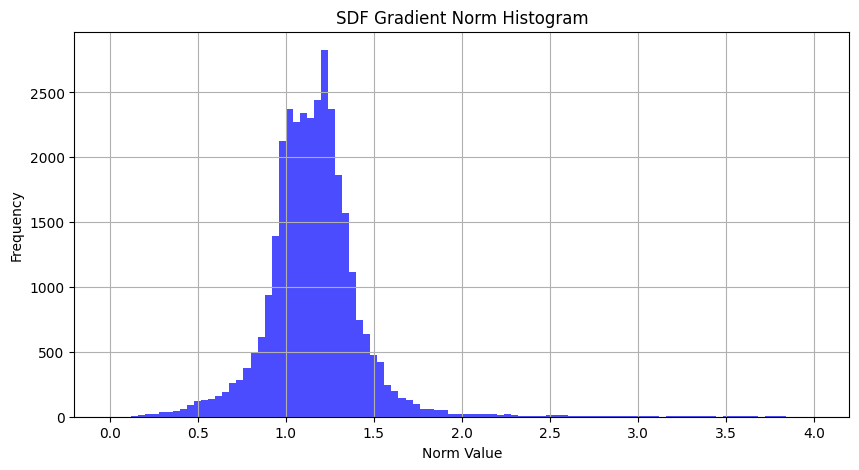

In [ ]:
def read_sdf_grad(input_path):
    # Read the file
    data = np.load(input_path)
    print("keys:",  [k for k in data.keys()])
    sites = data["sites"]
    sdf_values = data["sites_sdf"]
    d3dsimplices, _ = pygdel3d.triangulate(np.array(sites))

    sites = torch.tensor(sites, device=0)
    sdf_values = torch.tensor(sdf_values, device=0)
    d3dsimplices = torch.tensor(d3dsimplices, device=0)

    sites_sdf_grads, tets_sdf_grads, W = su.sdf_space_grad_pytorch_diego_sites_tets(
        sites, sdf_values, d3dsimplices
    )

    # Show sdf_grads
    print(sites_sdf_grads)

    # Compute norm
    site_sdf_grads_norm = torch.sqrt(torch.sum(sites_sdf_grads**2, dim=1))
    print(site_sdf_grads_norm)

    # Show the norm histogram
    plt.figure(figsize=(10, 5))
    # Range between 0 and 4
    plt.hist(site_sdf_grads_norm.cpu().numpy(), bins=100, color='blue', alpha=0.7, range=(0, 4))
    plt.title('SDF Gradient Norm Histogram')
    plt.xlabel('Norm Value')
    plt.ylabel('Frequency')
    plt.grid()
    plt.show()


read_sdf_grad("outputs/npz/DCCVT_0_final_DCCVT_cvt100_sdfsmooth0.npz")